In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
# from torchsummary import summary
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
# import tqdm.notebook.tqdm as tqdm
from sklearn.model_selection import train_test_split

In [2]:
if torch.cuda.is_available():
    print("The code will run on GPU. This is important so things run faster.")
else:
    print("The code will run on CPU. You should probably not do this.")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on CPU. You should probably not do this.


In [3]:
class dataset:
    def __init__(self,data,target):
        self.data = data
        self.target = target
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        X = self.data[idx]
        y = self.target[idx]
        
        return X,y

In [23]:
data = np.load('data.npy',allow_pickle=True)
target = np.load('target.npy',allow_pickle=True)

In [25]:
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        try:
            data[i,j,10] = int(str(data[i,j,10])[0])
        except:
            data[i,j,10] = 0

In [34]:
for i in range(target.shape[0]):
    try:
        target[i,10] = int(str(target[i,10])[0])
    except:
        target[i,10] = 0

In [35]:
data = data.astype("float")
target = target.astype("float")

In [36]:
data = torch.from_numpy(data).float()
target = torch.from_numpy(target).float()

train_idx,test_idx = train_test_split(np.arange(data.shape[0]),test_size=0.1)

train_data = data[train_idx,:,1:]
train_target = target[train_idx,1] #target is 1=profitloss
test_data = data[test_idx,:,1:]
test_target = target[test_idx,1] #target is 1=profitloss

trainset = dataset(train_data,train_target)
testset = dataset(test_data,test_target)

In [37]:
batch_size=50

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

In [39]:
temp = data.view(data.shape[0]*data.shape[1],data.shape[2])
temp = temp[:,1:temp.shape[1]].numpy()
temp = temp-np.ones((temp.shape[0],1))*temp.mean(0)
temp = temp*(1/np.std(temp,0))

In [43]:
from scipy.linalg import eigh

#compute covariance matrix
S = np.cov(temp.T)

#obtain eigen values and eigen vectors
eigenValues, eigenVectors = eigh(S)
idx_ord = np.argsort(eigenValues)[::-1]
eigenValues = eigenValues[idx_ord]
eigenVectors = eigenVectors[:,idx_ord]

#plot cummulative variance explained    
summ = eigenValues.sum()
cumsum = 0
total_var_explained = np.zeros(10)
for i in range(10):    
    cumsum = cumsum + eigenValues[i]
    total_var_explained[i]=(cumsum/summ)
    


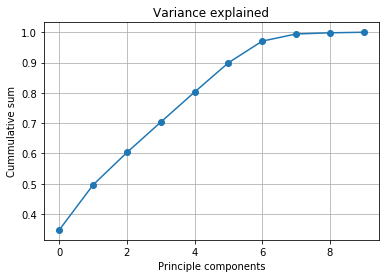

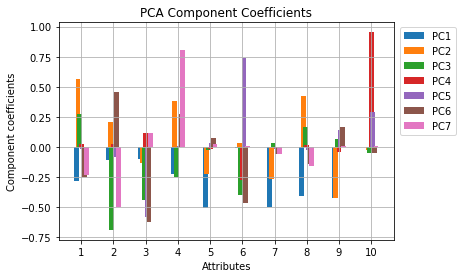

In [48]:
fig, ax = plt.subplots()
ax.plot(total_var_explained,'-o')
#ax.axhline(0.90,linestyle='--')
plt.grid();
#plt.xlim(-1,50)
#plt.ylim(0,1)
plt.title('Variance explained' )
plt.ylabel('Cummulative sum')
plt.xlabel('Principle components')
#plt.savefig("variance_explained")
plt.show()

M=10
pcs = np.arange(7)
#pcs = np.array([3,10])
legendStrs = ['PC'+str(e+1) for e in pcs]
c = ['r','g','b']
bw = .15
r = np.arange(1,M+1)
for i in pcs:    
   plt.bar(r+i*bw/3, eigenVectors[:,i], width=bw)
plt.xticks(r+bw, np.arange(1,13))
plt.xlabel('Attributes')
plt.ylabel('Component coefficients')
plt.legend(legendStrs,loc=1, bbox_to_anchor=(1.2,1))
plt.grid()
plt.title('PCA Component Coefficients')
plt.show()

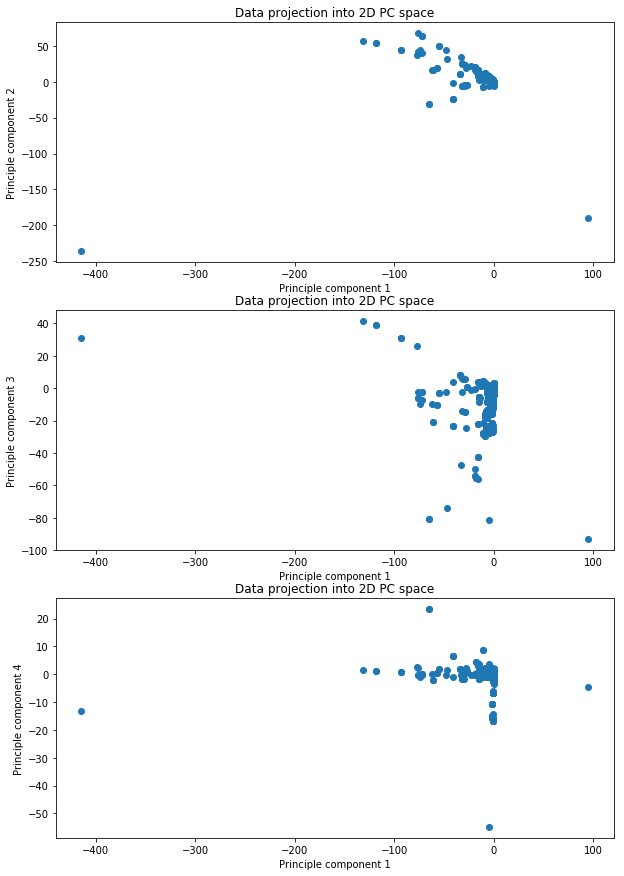

In [49]:
#Picking principle components to project the data into
eigenvectors1 = eigenVectors[:, 0]
eigenvectors2 = eigenVectors[:, 1]
eigenvectors3 = eigenVectors[:, 2]
eigenvectors4 = eigenVectors[:, 3]
eigenvectors = np.vstack((eigenvectors1,eigenvectors2,eigenvectors3,eigenvectors4)).T

## now we have to project our vectors in this new base
transformed_data = temp @ eigenvectors

fig,ax = plt.subplots(3,1,figsize=(10,15))
ax[0].scatter(transformed_data[:, 0], transformed_data[:, 1])
ax[0].set_title('Data projection into 2D PC space')
ax[0].set_xlabel('Principle component 1')
ax[0].set_ylabel('Principle component 2')
ax[1].scatter(transformed_data[:, 0], transformed_data[:, 2])
ax[1].set_title('Data projection into 2D PC space')
ax[1].set_xlabel('Principle component 1')
ax[1].set_ylabel('Principle component 3')
ax[2].scatter(transformed_data[:, 0], transformed_data[:, 3])
ax[2].set_title('Data projection into 2D PC space')
ax[2].set_xlabel('Principle component 1')
ax[2].set_ylabel('Principle component 4')
#plt.rcParams.update({'figure.autolayout': True})
plt.show()

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.linearIn = nn.Sequential(nn.Linear(in_features=5,out_features=15),
                                   nn.ReLU(),
                                   nn.Linear(15,30),
                                   nn.ReLU(),
                                   nn.Linear(30,50)) 
        self.rnn = nn.LSTM(input_size=50,
                          hidden_size=100,
                          num_layers=5,
                          batch_first=True)
        self.linearOut = nn.Sequential(nn.Linear(in_features=300,out_features=200),
                                     nn.ReLU(),
                                     nn.Linear(200,100),
                                     nn.ReLU(),
                                     nn.Linear(100,50),
                                     nn.ReLU(),
                                     nn.Linear(50,25),
                                     nn.ReLU(),
                                     nn.Linear(25,1)) #change to 2 for predicting normal distribution

        
    def forward(self, x): #x = [batch_size,3,5]
        x1 = self.linearIn(x[:,0,:]) #[batch_size,50]
        x2 = self.linearIn(x[:,1,:]) #[batch_size,50]
        x3 = self.linearIn(x[:,2,:]) #[batch_size,50]
        x1 = x1.unsqueeze(1) #[batch_size,1,50]
        x2 = x2.unsqueeze(1) #[batch_size,1,50]
        x3 = x3.unsqueeze(1) #[batch_size,1,50]     
        temp = []
        temp.append(x1)
        temp.append(x2)
        temp.append(x3)
        x = torch.cat(temp,dim=1) #[batch_size,3,50]                        
                                            
        x,_ = self.rnn(x) #[batch_size,3,100]
        x = x.reshape(x.shape[0],-1) #[batch_size,300]
                       
        x = self.linearOut(x) #[batch_size,2]
        x = x.view(-1)
        return x


In [12]:
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        
        self.linear = nn.Sequential(nn.Linear(in_features=15,out_features=50),
                                      nn.ReLU(),
                                      nn.Dropout(),
                                      nn.Linear(50,100),
                                      nn.ReLU(),
                                      nn.Dropout(),
                                      nn.Linear(100,200),
                                      nn.ReLU(),
                                      nn.Dropout(),
                                      nn.Linear(200,300),
                                      nn.ReLU(),
                                      nn.Dropout(),
                                      nn.Linear(300,200),
                                      nn.ReLU(),
                                      nn.Dropout(),
                                      nn.Linear(200,100),
                                      nn.ReLU(),
                                      nn.Dropout(),
                                      nn.Linear(100,50),
                                      nn.ReLU(),
                                      nn.Dropout(),
                                      nn.Linear(50,25),
                                      nn.ReLU(),
                                      nn.Dropout(),
                                      nn.Linear(25,1))

        
    def forward(self, x): #x = [batch_size,3,5]
        x = x.view(x.shape[0],-1)
        x = self.linear(x)
        x = x.view(-1)
        return x


In [13]:
def cost(mu,sigma,y):
    sigma = torch.abs(sigma)
    dist = torch.distributions.normal.Normal(mu, sigma)
    return torch.mean(-dist.log_prob(y)+sigma/10000)

In [16]:
model = Net2()
model.to(device)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
critirion = nn.L1Loss()

In [17]:
#Training loop
num_epochs = 20

for epoch in tqdm(range(num_epochs), unit='epoch'):
    #For each epoch
    train_error = 0
    for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
        data, target = data.to(device), target.to(device)
        #Zero the gradients computed for each weight
        optimizer.zero_grad()
        #Forward pass your image through the network
        output = model(data)
        #Compute the loss
        loss = critirion(output,target)
#         loss = cost(output[:,0],output[:,1], target)
        #Backward pass through the network
        loss.backward()
        #Update the weights
        optimizer.step()
        train_error += loss
        
    #Comput the test accuracy
    test_error = 0
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        with torch.no_grad():
            output = model(data)
#         test_error += cost(output[:,0],output[:,1],target)
        test_error += critirion(output,target)
    train_err = train_error/len(trainset)
    test_err = test_error/len(testset)
    print("train error: {train:.1f}\t test error: {test:.1f}".format(test=test_err, train=train_err))


train error: 197073.1	 test error: 98418.6



train error: 233749.9	 test error: 96866.1



train error: 209609.6	 test error: 98535.9



train error: 217516.5	 test error: 113019.3



train error: 212801.7	 test error: 116579.5



train error: 203176.1	 test error: 120361.4



train error: 205551.4	 test error: 132564.7



train error: 203290.1	 test error: 108140.8



train error: 205641.6	 test error: 93240.6



train error: 193341.9	 test error: 112864.6



train error: 186627.2	 test error: 232900.5



train error: 194611.5	 test error: 89759.1



train error: 180096.7	 test error: 104673.3



train error: 183019.7	 test error: 110690.2



train error: 189317.3	 test error: 110382.1



train error: 182345.6	 test error: 179527.1



train error: 192019.8	 test error: 125119.7



train error: 204831.4	 test error: 85835.5



train error: 199472.7	 test error: 117863.6



train error: 196367.9	 test error: 140480.5



In [18]:
print(data[2:3])
print(target[2:3])
temp =model(data[2:3])
print(temp)

tensor([[[-2.1542e+05,  9.1460e+03,  0.0000e+00,  2.6657e+05,  9.3387e+06],
         [-3.6445e+05,  0.0000e+00,  3.7690e+04,  0.0000e+00,  9.1613e+06],
         [ 8.6255e+05,  0.0000e+00,  5.6692e+05,  0.0000e+00,  1.4049e+07]]],
       device='cuda:0')
tensor([-5920729.5000], device='cuda:0')
tensor([1266374.2500], device='cuda:0', grad_fn=<ViewBackward>)


In [ ]:
[-215420,-364450,862550